# Homework 1: Supervised Learning
### Marco Giunta
----
**Abstract:** Two supervised learning problems are tackled using neural networks: regression and classification tasks are performed on toy datasets using fine tuned neural networks, whose hyperparameters are set using random grid searches.

# Introduction


The term *"supervised learning"* refers to a set of tools that attempt to solve the problem of learning patterns from labelled input data, with the idea that after training an algorithm it will be able to generalize and predict the unknown labels of new, unseen data. The two stereotypical supervised learning problems are *classification* and *regression*, their main difference being that in a classification task one tries to predict a discrete label (e.g. which class some object belongs to), whereas in a regression one the label in continuous (e.g. the value of an unknown function evaluated at a point).

*Supervised deep learning* in particular usually consists of defining and training a neural network, which is then trained using the backpropagation algorithm to compute the weights gradients - along with a rule to update said weight (e.g. SGD, Adam...); this is done to iteratively minimize a loss function, which quantifies the probability or the extent of predicting a wrong label.

# Regression task
## Introduction 

In the first part of the assignment we attempt to solve the problem of approximating an unknown function $f$ starting from a training dataset, which contains $(x,y)$ pairs where the label $y$ equals is $f(x)$ plus some noise; if learning is successful our network will be able to accurately reconstruct $f$, so that we can accurately approximate $f(x)$ even for $x$ values outside the training domain. Indeed this is exactly what we do to test performance: after training we compare the predicted and true labels of data in a test dataset, consisting of similar $(x,y) = (x,f(x)+\varepsilon)$ pairs but which are not used during training.
On one hand this approach is theoretically guaranteed to succeed, since neural networks are universal approximators and we're dealing with a simple smooth function; on the other there is no way to predict beforehand which et of hyperparameters is the one capable of reaching the theoretical optimal performance, so this task is far from trivial. This issue is dealt with using k-fold cross validation and a random grid search.

In [35]:
import torch
from torch import nn
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader
from scipy.stats import loguniform
from os.path import exists
from os import listdir
import os

In [36]:
# Let's start by importing and visualizing our datasets

class RegressionDataset(Dataset):
    def __init__(self, file_path: str = None, df: pd.DataFrame = None): # it's useful e.g. for plotting reasons to keep a copy of the original dataframe
        if file_path is not None:
            self.df = pd.read_csv(file_path)
        elif df is not None:
            self.df = df
        else:
            raise RuntimeError()
        self.tensor = (torch.tensor(self.df.input.to_numpy()), torch.tensor(self.df.label.to_numpy())) # data in tuple of 2 tensors format

    def __getitem__(self, index):
        x, y = self.df.iloc[index]
        return (torch.tensor([x]), torch.tensor([y]))

    def __len__(self):
        return len(self.df)

    def __str__(self):
        return str(self.df) # we borrow pandas.DataFrame's str for print
    
    def _repr_html_(self):
        return self.df._repr_html_() # we borrow pandas.DataFrame's repr html for HTML display in jupyter

train_data = RegressionDataset('./regression_dataset/train_data.csv')
test_data = RegressionDataset('./regression_dataset/test_data.csv')
print(f'training set size = {len(train_data)}')
print(f'test set size = {len(test_data)}')

training set size = 100
test set size = 100


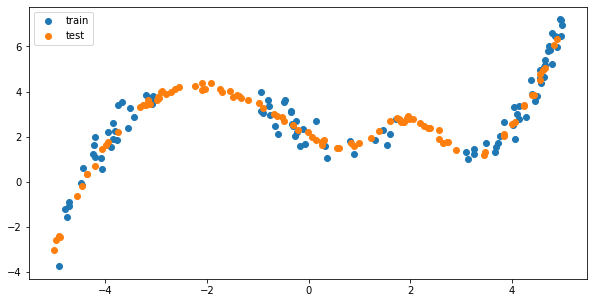

In [37]:
fig, ax = plt.subplots(figsize = (10,5))
ax.scatter(train_data.df.input, train_data.df.label, label = 'train')
ax.scatter(test_data.df.input, test_data.df.label, label = 'test') # a lot less noise in the test dataset --> it's possible the final test error will be lower than the final training error
ax.legend();

## Methods
Notice that since this task is very simple a neural network can become very good at it - too good, in fact! The risk of overfitting is high, so it's advisable to keep complexity as low as possible (e.g. by using small networks, regularization techniques, etc.). At the same time we notice that complex networks (e.g. large ones) usually require large amounts of data to be successfully trained, and yet our dataset is quite small (only 100 samples); we conclude that both the task and the available data constrain the choice of hyperparameters.

To perform this choice we use *random grid search* i.e. we sample a set of hyperparameters as explained below, then we estimate the validation error using 5-fold cross validation (to avoid wasting a significant fraction of the few precious available samples). The hyperparameters are evaluated as follows:
- *NN architecture*: one cause of overfitting is network complexity as measured by the number of neurons/layers. Due to our simplicity constraint we therefore look for *small networks*, e.g. networks with at most 5 layers and at most 15-20 neurons per layer. This still leaves us with a huge number of possibilities, too many to be effectively explored with a grid search scheme; therefore we restrict our search to netorks of only three shapes, with the hope that it's still enough to capture a good amount of variability inside hyperparameters space. In particular we consider networks of "constant shape", i.e. with 1-5 layers all made of 2-15 neurons; networks of "increasing shape", i.e. with 1-5 layers where the first one has 2-4 neurons and each of the following has double the number of neurons than the previous; finally networks with "increase" as in the previous case, but that after the middle layer start decreasing in order to have a symmetrical shape. These three shapes define the probability distribution form which we sample the network architecture; once this sampling has been made we construct `Linear` layers with a nonlinear activation function between them.
- *Activation function*: we randomly pick either a `ReLU`, `LeakyReLU`, `Tanh` or `Sigmoid` activation function - even though we perform the first two to perform better, since they don't suffer from the vanishing gradients problem as much as the last two. Notice that no activation is applied to the output layer, since we don't really need it (e.g. no softmax since we don't need normalized outputs, etc.).
- *Optimizer*: we randomly pick either `SGD` with Nesterov momentum, `Adam` or `RMSprop`. No learning rate scheduler is employed on top of Adam's and RMSprop's builtin ones
- *Initial learning rate*: sampled from a loguniform distribution between $10^{-4}$ and $10^{-1}$, so that any o.o.m. between $-4$ and $-1$ is equally probable (this allows us to sample a large range of values, since we scale logarithmically). This range is chosen since common values for the learning rate are "small", i.e. smaller than 1.
- *Batch size*: either 5, 7, 10 or 15 with uniform probability (fairly standard values for a small dataset).
- *Regularization*: we either employ no regularization at all, dropout, $L2$ or $L1$ norm regularization - because due to the above some amount of regularization may be desirable. Notice that dropout and L1/L2 regularization can cohexist since they have different ways of contrasting overfitting: the former keeps down complexity (thus overfitting risk) as measured by weight norms, the latter ensures better we avoiding too strong a dependence on single neurons (thus reducing the risk of poor generalization properties, which indeed equal overfitting); and yet we only choose one of the two (or none at all) to regularize the network, as a means of reducing the hyperparameter space's dimensionality. Therefore we either choose dropout with a drop rate between $1\%$ and $50\%$ with loguniform probability, $L1$/$L2$ regularization with a loguniformly distributed strength between $10^{-5}$ and $10^{-1}$, or no regularization. Notice that we avoid too large dropout rate values because dropout (if present) is uniformly applied to all layers, input one included; while this is fine for multi-input situations in our case it means that some training iterations may essentially be fully randomized - not necessarily a bad outcome, at least as long as the dropout rate is small enough; we'll let the grid search decide.

Both during grid search and the improved training of the best network *early stopping* was employed by using a *patience* of 10 epochs: if the validation error doesn't improve for 10 epochs training is stopped. Since NN training is stochastic in nature "no validation error improvement" is defined as having a current validation error larger than the best previous one *plus* a tolerance parameter, which was set to $0.01$ since we aim for contenders with validation errors differing by $~0.01$ (this can be found by experimenting a bit). This early stopping rule is employed both to avoid situations where the training error improves much faster than the validation one (thus potentially leading to overfitting) and to speed up convergence. Notice, though, that training is never stopped before 20 iterations.
Sampling according to the aforementioned distributions about 350 trials were performed, each evaluated using CV; if no early stopping occurs then training is stopped at 150 epochs during training. Finally we pick the 10 best networks, then retrain them for 1000 epochs (again with early stopping) to choose the final network.

As a final notice we remark that under all circumstances an `MSELoss` is used, as is customary for simple regression tasks.


In [38]:
# k-fold cv: we define an iterator that yields multiple pairs of dataloaders associated to the training/validation set, where each pair is constructed using a different fold configuration

def kfold_dataloaders(train_data: RegressionDataset, n_folds: int, batch_size: int, seed: int = 1234, shuffle: bool = True, n_workers: int = 0):
    if seed is not None:
        np.random.seed(seed) # we fix the seed to ensure reproducibility
        torch.random.manual_seed(seed)
        torch.cuda.random.manual_seed(seed)
    
    train_df = train_data.df
    kf = KFold(n_splits = n_folds, random_state = seed, shuffle = shuffle)
    for train_idx, val_idx in kf.split(train_df):
        train_df_kfold = train_df.iloc[train_idx] # we feed dataframes to RegressionDataset directly instead of reading from disk
        val_df_kfold   = train_df.iloc[val_idx]

        train_data_kfold, val_data_kfold = RegressionDataset(df = train_df_kfold), RegressionDataset(df = val_df_kfold)
        train_data_kfold_dataloader, val_data_kfold_dataloader = DataLoader(train_data_kfold, batch_size = batch_size, shuffle = shuffle, num_workers = n_workers), DataLoader(val_data_kfold, batch_size = batch_size, shuffle = shuffle, num_workers = n_workers)
        yield train_data_kfold_dataloader, val_data_kfold_dataloader

In [39]:

class RegressionNetLight(nn.Module): # we define a barebones class, which contains enough methods to be trainable; we'll later add functions to plot, predict, etc. later. For now we keep memory consumption as low as possible
    def __init__(self, hidden_layers_architecture: tuple, activation_function: str, optimizer: str, 
                 initial_lr: float, batch_size: int, dropout: float = None, l1_reg_strength: float = None, l2_reg_strength: float = None, 
                 loss_fn = nn.MSELoss()):
        
        super().__init__()
        self.n_neurons_per_layer = [1, *hidden_layers_architecture, 1] # 1 neuron input layer (since the input is a scalar), argument-fed hidden layers structure, 1 neuron output layer (since the output is a scalar)
        nn_architecture = [nn.Linear(in_features = self.n_neurons_per_layer[i], out_features = self.n_neurons_per_layer[i+1]) for i in range(len(self.n_neurons_per_layer)-1)]
        self.nn_layers = nn.ModuleList(nn_architecture) # a sequence of linear layers with nonlinear activations in between
        self.activation = getattr(nn, activation_function)()
        
        if dropout is not None and 0 < dropout < 1:
            self.dropout = dropout
            self.dropout_layer = nn.Dropout(p = dropout)
        else:
            self.dropout = None
            self.dropout_layer = nn.Identity() # if no dropout the dropout layer is the identity, i.e. it actually does nothing

        if optimizer == 'SGD': # if optimizer is SGD we add Nesterov momentum with a 0.9 fairly standard value
            self.optimizer = torch.optim.SGD(params = self.parameters(), momentum = 0.9, nesterov = True, lr = initial_lr)
        else:
            self.optimizer = getattr(torch.optim, optimizer)(params = self.parameters(), lr = initial_lr)
        
        self.batch_size = batch_size
        self.loss_fn = loss_fn
        self.l1_reg_strength = l1_reg_strength
        self.l2_reg_strength = l2_reg_strength

        if l1_reg_strength is None and l2_reg_strength is None:
            self.reg = lambda: torch.tensor([0], dtype = float, requires_grad = True)
        if l1_reg_strength is not None:
            self.reg = lambda: sum(((w.abs()).sum() for w in self.parameters()))*self.l1_reg_strength
        if l2_reg_strength is not None:
            self.reg = lambda: sum(((w**2).sum() for w in self.parameters()))*self.l2_reg_strength            
    
    def forward(self, x): # forward pass function
        for layer in self.nn_layers[:-1]: 
            x = self.dropout_layer(self.activation(layer(x))) 
        x = self.nn_layers[-1](x)
        return x

    def train_single_epoch_and_fold(self, train_fold): # function to be iterated inside a nested loop
        self.train() # enable dropout etc.
        tr_err_single_epoch_and_fold = 0

        for x_batch, y_batch in train_fold:
            output = self(x_batch)
            loss   = self.loss_fn(output, y_batch) + self.reg()
            self.optimizer.zero_grad() # reset gradients
            loss.backward() # backpropagation
            self.optimizer.step() # update weights
            tr_err_single_epoch_and_fold += loss.detach().cpu().numpy() # save current training error
        
        tr_err_single_epoch_and_fold /= len(train_fold)
        return tr_err_single_epoch_and_fold

    @torch.no_grad()
    def val_single_epoch_and_fold(self, val_fold):
        self.eval() # disable dropout etc.
        val_err_single_epoch_and_fold = 0

        for x_batch, y_batch in val_fold:
            output = self(x_batch)
            loss   = self.loss_fn(output, y_batch)
            val_err_single_epoch_and_fold += loss.detach().cpu().numpy()
        
        val_err_single_epoch_and_fold /= len(val_fold)
        return val_err_single_epoch_and_fold

    # main training method. I like scikit-learn's self-contained API, hence what follows
    def fit(self, train_data: RegressionDataset, n_folds: int = 5, max_n_iter: int = 500, min_n_iter: int = 20, patience: int = 10, tol: float = 0.01, seed: int = 1234, verbose: bool = True):
        if seed is not None: # default seed to ensure reproducibility
            torch.random.manual_seed(seed)

        self.avg_training_error_history, self.avg_val_error_history = np.zeros(max_n_iter), np.zeros(max_n_iter) # "avg" since in CV one estimates error by averaging over different fold configurations
        self.best_val_error = np.Inf
        patience_counter = 0

        loading = trange(max_n_iter) if verbose else range(max_n_iter) # useful toggle during training/debugging
        for epoch in loading:
            tr_err_buffer, val_err_buffer = np.zeros(n_folds, dtype = float), np.zeros(n_folds, dtype = float)
            # we iterate over fold configurations
            for fold_idx, (train_fold, val_fold) in enumerate(kfold_dataloaders(train_data = train_data, n_folds = n_folds, batch_size = self.batch_size)): 
                tr_err_buffer[fold_idx]  = self.train_single_epoch_and_fold(train_fold)
                val_err_buffer[fold_idx] = self.val_single_epoch_and_fold(val_fold)
            # we average over fold configurations to estimate errors
            self.avg_training_error_history[epoch] = tr_err_buffer.mean()
            val_err = self.avg_val_error_history[epoch] = val_err_buffer.mean() 

            if epoch > min_n_iter:
                if val_err > self.best_val_error + tol:
                    patience_counter += 1
                else:
                    self.best_val_error = val_err
                    patience_counter = 0
                if patience_counter > patience:
                    # n_executed_epochs = epoch
                    break
        n_executed_epochs = epoch + 1 # + 1 to go from 0, N-1 (python) to 1, N (human readable) counting scheme 
        if n_executed_epochs < max_n_iter:
            self.best_val_error_epoch = n_executed_epochs - patience_counter
        else:
            self.best_val_error_epoch = max_n_iter - patience_counter

In [40]:
# Random Grid Search
def sample_hyperparameters(seed):
    np.random.seed(seed) # also used by scipy.stats
    # Architecture
    n_hidden_layers = np.random.randint(1, 6) # [1,5]

    if n_hidden_layers == 1:
        architecture_style = 'constant'
    elif n_hidden_layers == 2:
        architecture_style = np.random.choice(['constant', 'increase'])
    else:
        architecture_style = np.random.choice(['constant', 'increase', 'increase-decrease'])
    
    if architecture_style == 'constant':
        n_neurons = np.random.randint(2, 16) # [2,15]
        hidden_layers_architecture = (n_neurons,) * n_hidden_layers
    elif architecture_style == 'increase':
        n_neurons_first_layer = np.random.randint(2, 5) # [2,4]
        hidden_layers_architecture = tuple(n_neurons_first_layer * 2**np.arange(n_hidden_layers))
    else: # increase-decrease
        n_neurons_first_layer = np.random.randint(2, 5) # [2,4]
        if n_hidden_layers % 2 == 0: # even number of layers --> the two in the middle are equal, two mirror halves
            n_neurons_first_layer = np.random.randint(2, 5) # [2,4]
            tmp = n_neurons_first_layer * 2**np.arange(n_hidden_layers//2)
            hidden_layers_architecture = tuple([*tmp, *(tmp[::-1])])
        else: # odd number of layer --> a single middle layer with no partner
            n_neurons_first_layer = np.random.randint(2, 5) # [2,4]
            tmp1 = n_neurons_first_layer * 2**np.arange(n_hidden_layers//2+1) # up to 2^(n/2-0.5)
            tmp2 = n_neurons_first_layer * 2**np.arange(n_hidden_layers//2-1,-1,-1) # starting from 2^(n/2-1.5)
            hidden_layers_architecture = tuple([*tmp1, *tmp2])
    
    # Most other stuff
    activation_function = np.random.choice(['ReLU', 'LeakyReLU', 'Tanh', 'Sigmoid'])
    optimizer = np.random.choice(['SGD','Adam', 'RMSprop'])
    initial_lr = loguniform.rvs(1e-4, 1e-1)
    batch_size = int(np.random.choice([5, 7, 10, 15])) # int casting is necessary due to a bug in torch/utils/data/sampler.py (where python integers are fine but not numpy ones)

    # Regularization
    reg = {'dropout':None, 'l1_reg_strength':None, 'l2_reg_strength':None}
    reg_type = np.random.choice([None, *reg.keys()])
    if reg_type is not None:
        if reg_type == 'dropout':
            reg['dropout'] = loguniform.rvs(0.01, 0.5) # 1% to 50%
        else:
            reg[reg_type] = loguniform.rvs(1e-5, 1e-1)
    
    hyperparameters = {'hidden_layers_architecture':hidden_layers_architecture, 'activation_function':activation_function,'optimizer':optimizer,
                       'initial_lr':initial_lr, 'batch_size':batch_size, **reg}
    
    return hyperparameters

def run_one_instance(seed, max_n_iter = 150, verbose = True): # one instance of the random grid search: sample a set of hp, then train for up to 150 epochs
    hyperparameters = sample_hyperparameters(seed)
    model = RegressionNetLight(**hyperparameters)
    model.fit(train_data, verbose = verbose, max_n_iter = max_n_iter)
    return {'seed':seed, **hyperparameters, 'best_val_error':model.best_val_error, 'best_val_error_epoch':model.best_val_error_epoch}

def run_multiple_instances(start_seed, stop_seed, base_file_path = 'D:/NNDL/homework/HW1/regression_random_search_single_files/'): # multiple instances of the above to test a larger than 1 set of hyperparameters
    hp = ['seed', 'hidden_layers_architecture', 'activation_function', 'optimizer', 'initial_lr', 'batch_size', 'dropout', 'l1_reg_strength', 'l2_reg_strength', 'best_val_error', 'best_val_error_epoch']
    for seed in range(start_seed, stop_seed): # we test seeds between the two arguments
        print(f'Training with seed {seed}')
        file_path = base_file_path + f'seed_{seed}.csv'
        df = pd.DataFrame({s:[] for s in hp}) # create empty dataframe
        df = df.append(run_one_instance(seed), ignore_index = True) # fill 1 row with training results
        df.astype({'seed':int, 'best_val_error_epoch':int, 'batch_size':int}).to_csv(file_path, index_label = False)
        print(f'Saved to file {file_path}') # save csv with 1 training result
        # a more elegant approach would be to stream results to a database, or even to just iteratively dump them in a json; and yet creating many small csv's is much easier and efficient enough, so it suffices.


In [41]:
# the run_multiple_instances function above was actually run interactively from terminal not to pollute the notebook.
# In particular a scripted version of the above cell was used, plus a wapper to accept user input and logic to process a KeyboardInterrupt event (this script is included, but it's not really interesting since
# it contains exactly the same code as above).

# assemble random grid search results in a single dataframe
results_file_path = './regression_random_search_result.csv'
if not exists(results_file_path):
    csvs_folder = './regression_random_search_single_files/'
    df = pd.concat((pd.read_csv(csvs_folder + f) for f in listdir(csvs_folder))) # pd.concat(generator i.e. via generator comprehension)
    df.to_csv(results_file_path, index_label = False)
else:
    df = pd.read_csv(results_file_path)
# show results
best_nn_df = df.nsmallest(10, 'best_val_error').reset_index(drop = True)
best_nn_df.index += 1
display(best_nn_df)

if not exists('./regression_best_networks.csv'):
    best_nn_df.to_csv('./regression_best_networks.csv')

,seed,hidden_layers_architecture,activation_function,optimizer,initial_lr,batch_size,dropout,l1_reg_strength,l2_reg_strength,best_val_error,best_val_error_epoch
1,340,"(4, 8, 16, 32, 64)",LeakyReLU,Adam,0.001070,15,NaN,NaN,0.000111,0.245075,150
2,243,"(9, 9)",Tanh,Adam,0.001092,5,NaN,0.000607,NaN,0.258453,150
3,278,"(15,)",Tanh,Adam,0.003613,7,NaN,NaN,NaN,0.275100,150
4,206,"(6, 6, 6)",Tanh,RMSprop,0.005561,10,NaN,NaN,NaN,0.275148,150
5,343,"(14, 14)",ReLU,RMSprop,0.001820,5,NaN,NaN,NaN,0.279779,150
6,204,"(7, 7)",LeakyReLU,Adam,0.006676,15,NaN,0.000196,NaN,0.282392,150
7,16,"(11, 11)",LeakyReLU,Adam,0.000843,7,NaN,NaN,0.006574,0.285551,150
8,279,"(10, 10)",Sigmoid,SGD,0.016119,10,NaN,NaN,0.000013,0.290088,150
9,313,"(12,)",Sigmoid,Adam,0.007142,5,NaN,0.001752,NaN,0.290173,150
10,34,"(12, 12)",LeakyReLU,RMSprop,0.001795,15,0.014876,NaN,NaN,0.291580,150


In [42]:
# We overhaul the basic class defined above by adding some plotting functions, while also keeping track of training/validation error std during training.
class RegressionNet(RegressionNetLight):
    def __init__(self, hidden_layers_architecture: tuple, activation_function: str, optimizer: str, 
                 initial_lr: float, batch_size: int, dropout: float = None, l1_reg_strength: float = None, l2_reg_strength: float = None, 
                 loss_fn = nn.MSELoss()):
        super().__init__(hidden_layers_architecture = hidden_layers_architecture, activation_function = activation_function, optimizer = optimizer, 
                         initial_lr = initial_lr, batch_size = batch_size, dropout = dropout, l1_reg_strength = l1_reg_strength, l2_reg_strength = l2_reg_strength, 
                         loss_fn = loss_fn)

    def fit(self, train_data: RegressionDataset, n_folds: int = 5, max_n_iter: int = 500, min_n_iter: int = 20, patience: int = 10, tol: float = 0.01, seed: int = 1234, verbose: bool = True): # , verbose: bool = True
        if seed is not None:
            torch.random.manual_seed(seed)
        self.avg_training_error_history, self.avg_val_error_history = np.zeros(max_n_iter), np.zeros(max_n_iter)
        self.std_training_error_history, self.std_val_error_history = np.zeros(max_n_iter), np.zeros(max_n_iter) # new addition
        self.best_val_error = np.Inf
        patience_counter = 0
        loading = trange(max_n_iter) if verbose else range(max_n_iter)
        for epoch in loading:
            tr_err_buffer, val_err_buffer = np.zeros(n_folds, dtype = float), np.zeros(n_folds, dtype = float)
            for fold_idx, (train_fold, val_fold) in enumerate(kfold_dataloaders(train_data = train_data, n_folds = n_folds, batch_size = self.batch_size)): 
                tr_err_buffer[fold_idx]  = self.train_single_epoch_and_fold(train_fold)
                val_err_buffer[fold_idx] = self.val_single_epoch_and_fold(val_fold)

            self.avg_training_error_history[epoch] = tr_err_buffer.mean()
            val_err = self.avg_val_error_history[epoch] = val_err_buffer.mean() 
            self.std_training_error_history[epoch] = tr_err_buffer.std() # new addition
            self.std_val_error_history[epoch] = val_err_buffer.std()

            if epoch > min_n_iter:
                if val_err > self.best_val_error + tol:
                    patience_counter += 1
                else:
                    self.best_val_error = val_err
                    patience_counter = 0
                if patience_counter > patience:
                    break
        n_executed_epochs = epoch + 1
        if n_executed_epochs < max_n_iter:
            self.best_val_error_epoch = n_executed_epochs - patience_counter
        else:
            self.best_val_error_epoch = max_n_iter - patience_counter
    
    def predict(self, x: torch.Tensor):
        self.eval()
        return self(x.float().unsqueeze(1))

    def plot_regression_curve(self, train_data: RegressionDataset, test_data: RegressionDataset, figsize: tuple = (10,5)):
        x0, x1 = min(train_data.df.input.min(), test_data.df.input.min()), max(train_data.df.input.max(), test_data.df.input.max())
        x = torch.linspace(x0, x1, 1000)
        y = self.predict(x = x)

        y_test_true, y_test_pred = test_data.tensor[1].unsqueeze(1), self.predict(test_data.tensor[0])
        test_error = self.loss_fn(y_test_true, y_test_pred)
        x, y = x.detach().numpy(), y.detach().numpy()

        fig, ax = plt.subplots(figsize = figsize)
        ax.scatter(train_data.df.input, train_data.df.label, label = 'training data')
        ax.scatter(test_data.df.input, test_data.df.label, label = 'test data')
        ax.plot(x, y, label = 'regression curve', linewidth = 4, color = 'red')
        ax.legend()
        ax.set_title(f'MSE test error = {test_error:.3f}')
        ax.set_xlabel(r'input $x$')
        ax.set_ylabel(r'label $y \approx f(x)$')
        return fig, ax
    
    def plot_learning_curves(self, smooth: int = None, figsize: tuple = (10,5)):
        if smooth is not None:
            tr_avg,  tr_std  = np.convolve(self.avg_training_error_history, np.ones(smooth)/smooth, mode = 'valid'), np.convolve(self.std_training_error_history, np.ones(smooth)/smooth, mode = 'valid')
            val_avg, val_std = np.convolve(self.avg_val_error_history, np.ones(smooth)/smooth, mode = 'valid'), np.convolve(self.std_val_error_history, np.ones(smooth)/smooth, mode = 'valid')
        else:
            tr_avg,  tr_std  = self.avg_training_error_history, self.std_training_error_history
            val_avg, val_std = self.avg_val_error_history,      self.std_val_error_history
        
        epochs = np.arange(len(tr_avg))
        fig, ax = plt.subplots(figsize = figsize)
        ax.plot(epochs, tr_avg,  label = 'training error',   c = 'b', linewidth = 3)
        ax.plot(epochs, val_avg, label = 'validation error', c = 'r', linewidth = 3)
        ax.fill_between(epochs, tr_avg - tr_std, tr_avg + tr_std, alpha = 0.5, color = 'blue')
        ax.fill_between(epochs, val_avg - val_std, val_avg + val_std, alpha = 0.5, color = 'orange')
        ax.set_yscale('log')
        ax.set_xlabel('epoch')
        ax.set_ylabel('error')
        ax.legend()
        ax.set_title('Learning curves (tr./val.)')

        return fig, ax

    def plot_weight_histogram(self, figsize: tuple = (25, 5)):
        fig, ax = plt.subplots(nrows = 1, ncols = len(self.nn_layers), figsize = figsize)
        fig.suptitle('Weight histograms')
        for i, axx in enumerate(ax.flatten()):
            w = self.nn_layers[i].weight.detach().numpy()
            axx.hist(w[np.abs(w - w.mean()) < 2*w.std()])
            axx.set_title(f'FC Layer {i+1}')

        return fig, ax


We can now retrain these networks for 1000 epochs (with early stopping still active); this makes sense because none of the 10 best networks reached the early stopping condition in 150 epochs, which means all of them can potentially still improve.

In [43]:
# Refined grid search (this can be executed within the notebook, no need for external scripts)

final_csv_file_path = 'regression_best_networks_long_training.csv'

if not exists(final_csv_file_path):
    seed_list = best_nn_df.seed.to_list()
    base_path_model_parameters = './regression_best_models_parameters_long_training/'
    val_err_list, val_err_epoch_list = [], []
    for seed in seed_list:
        file_path = base_path_model_parameters + f'seed_{seed}.pth'
        model = RegressionNet(**sample_hyperparameters(seed))
        if not exists(file_path):
            model.fit(train_data, max_n_iter = 1000)
            torch.save(model.state_dict(), file_path)
            val_err_list.append(model.best_val_error)
            val_err_epoch_list.append(model.best_val_error_epoch)

    best_nn_df_long_training = best_nn_df.copy().reset_index(drop = True)
    best_nn_df_long_training['best_val_error_long']       = val_err_list
    best_nn_df_long_training['best_val_error_epoch_long'] = val_err_epoch_list
    best_nn_df_long_training.to_csv(final_csv_file_path, index = False)

else:
    best_nn_df_long_training = pd.read_csv(final_csv_file_path)

print('Results after (up to) 1000 epochs:')
display(best_nn_df_long_training)
print('Best performing network:')
display(best_nn_df_long_training.nsmallest(1, 'best_val_error_long'))

Results after (up to) 1000 epochs:


,seed,hidden_layers_architecture,activation_function,optimizer,initial_lr,batch_size,dropout,l1_reg_strength,l2_reg_strength,best_val_error,best_val_error_epoch,best_val_error_long,best_val_error_epoch_long
0,340,"(4, 8, 16, 32, 64)",LeakyReLU,Adam,0.001070,15,NaN,NaN,0.000111,0.245075,150,0.217176,1000
1,243,"(9, 9)",Tanh,Adam,0.001092,5,NaN,0.000607,NaN,0.258453,150,0.226597,1000
2,278,"(15,)",Tanh,Adam,0.003613,7,NaN,NaN,NaN,0.275100,150,0.216849,1000
3,206,"(6, 6, 6)",Tanh,RMSprop,0.005561,10,NaN,NaN,NaN,0.275148,150,0.267141,217
4,343,"(14, 14)",ReLU,RMSprop,0.001820,5,NaN,NaN,NaN,0.279779,150,0.206888,1000
5,204,"(7, 7)",LeakyReLU,Adam,0.006676,15,NaN,0.000196,NaN,0.282392,150,0.270631,112
6,16,"(11, 11)",LeakyReLU,Adam,0.000843,7,NaN,NaN,0.006574,0.285551,150,0.256837,1000
7,279,"(10, 10)",Sigmoid,SGD,0.016119,10,NaN,NaN,0.000013,0.290088,150,0.253786,1000
8,313,"(12,)",Sigmoid,Adam,0.007142,5,NaN,0.001752,NaN,0.290173,150,0.247838,1000
9,34,"(12, 12)",LeakyReLU,RMSprop,0.001795,15,0.014876,NaN,NaN,0.291580,150,0.246350,1000


Best performing network:


,seed,hidden_layers_architecture,activation_function,optimizer,initial_lr,batch_size,dropout,l1_reg_strength,l2_reg_strength,best_val_error,best_val_error_epoch,best_val_error_long,best_val_error_epoch_long
4,343,"(14, 14)",ReLU,RMSprop,0.00182,5,NaN,NaN,NaN,0.279779,150,0.206888,1000


## Results

Our parameters of choice are the following:

In [44]:
best_nn_seed = int(best_nn_df_long_training.nsmallest(1, 'best_val_error_long').seed)
display(best_nn_df_long_training.nsmallest(1, 'best_val_error_long'))

,seed,hidden_layers_architecture,activation_function,optimizer,initial_lr,batch_size,dropout,l1_reg_strength,l2_reg_strength,best_val_error,best_val_error_epoch,best_val_error_long,best_val_error_epoch_long
4,343,"(14, 14)",ReLU,RMSprop,0.00182,5,NaN,NaN,NaN,0.279779,150,0.206888,1000


We can now evaluate the performance of the neural network by comparing true and predicted values for samples in the test dataset.

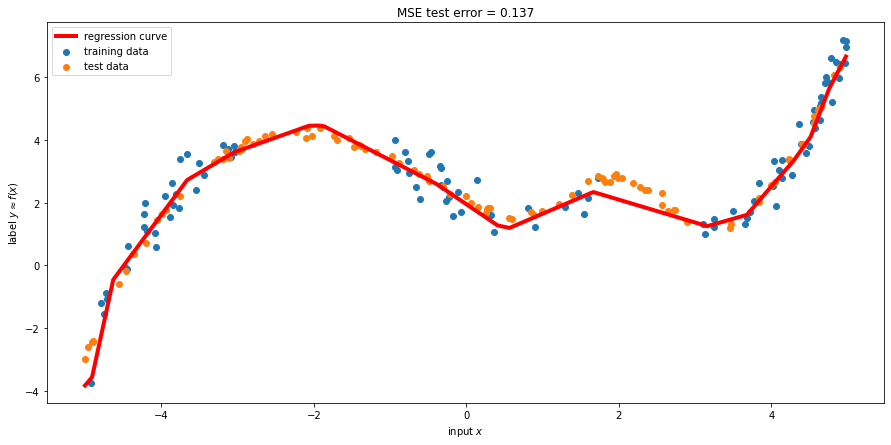

In [45]:
best_nn = RegressionNet(**sample_hyperparameters(best_nn_seed))
# best_nn.fit(train_data, max_n_iter = 1000) # precomputed parameters
best_nn.load_state_dict(torch.load(f'./regression_best_models_parameters_long_training/seed_{best_nn_seed}.pth')) # we recycle the training done above
best_nn.plot_regression_curve(train_data, test_data, figsize = (15,7));

Performance is quite good, with an MSE test error of $\sim 0.14$ (even though it can reach $\sim 0.22$ depending on the training seed). We notice that the two regions missing in the training data are well reconstructed, especially around $x=-2$; around $x=2$, instead, the network is significantly biased towards the training data. In particular we observe that the network tries to bridge the gap between known samples by staying as close to them as possible, resulting in a curve which isn't tall enough around $x=2$ and resulting a region which is the main contributor to the test error. Still the performance is quite good, so there's no need to adress this fact e.g. by strengthening the regularization amount; we can confidently state that learning was successful.

A remarkable result is that the test error ($\sim 0.14$) is significantly smaller than the validation error ($\sim 0.21$); this is uncommon, but not surprising. Indeed notice that the training data are significantly more noisy than the test samples; this means that in its effort to find the average curve between training points the network actually finds an excellent approximation to points without much noise.

Finally to gain insight about what the network is doing (i.e. to reach interpretability to some extent) we plot the activation profiles (i.e. neurons output) when the input is the $[-5,5]$ range we're interested in.

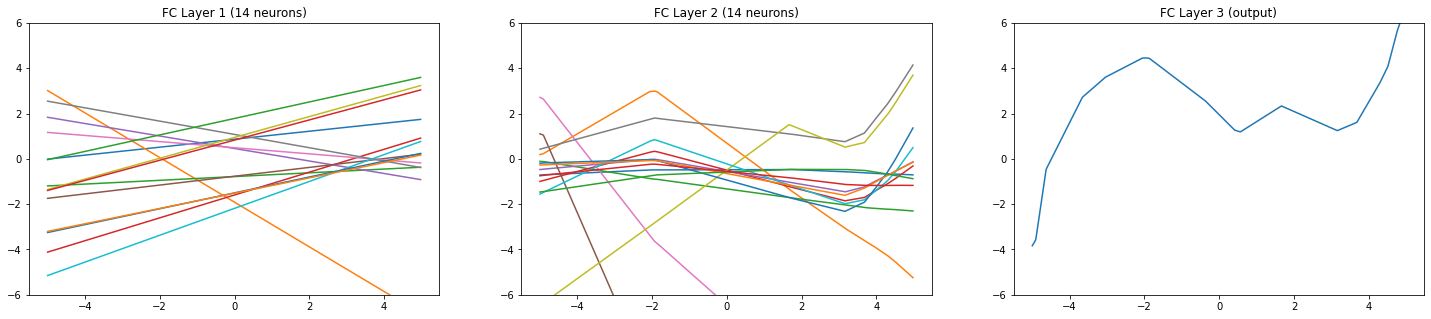

In [46]:
model = RegressionNet(**sample_hyperparameters(best_nn_seed)) # a copy to avoid messing with the layers
model.load_state_dict(torch.load(f'./regression_best_models_parameters_long_training/seed_{best_nn_seed}.pth'))

class SaveOutput: # https://towardsdatascience.com/the-one-pytorch-trick-which-you-should-know-2d5e9c1da2ca
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []

save_output = SaveOutput()

hook_handles = []

for layer in model.modules():
    if isinstance(layer, torch.nn.Linear):
        handle = layer.register_forward_hook(save_output)
        hook_handles.append(handle)

x0, x1 = min(train_data.df.input.min(), test_data.df.input.min()), max(train_data.df.input.max(), test_data.df.input.max())
x = torch.linspace(x0, x1, 1000).unsqueeze(1)
y = model(x)
x = x.detach().numpy()

out = save_output.outputs

fig, ax = plt.subplots(nrows = 1, ncols = len(out), figsize = (25, 5))
for i, axx in enumerate(ax.flatten()):
    layer_activation = out[i].T # every row is now a neuron activation
    s = layer_activation.shape[0]
    s = str(s) + ' neurons' if s > 1 else 'output'
    axx.set_title(f'FC Layer {i+1} ({s})')
    for neuron_activation in layer_activation:
        axx.plot(x, neuron_activation.detach().numpy())
        axx.set_ylim([-6,6])


We notice that complexity increases as we go deeper into the network. In particular in the first layer the neurons are essentially linear units (i.e. they behave similarly to perceptrons), which means they simply reproduce the input times a constant - thus allowing them to differentiate the position of the provided input in the function domain. Notice each neuron doesn't activate for inputs in a certain range, so the first layer purely allows the network to classify input positions (without actually predicting the label). In the second layer the network start actually modelling the function: we can clearly see some neurons approximating parts of the function - which is especially evident in $x=\pm 2$, where the function's peaks start appearing; this is further refined in the last layer, which is the output one and thus yields the actual prediction.

An interesting result is that some neurons in the second layer almost don't activate for any input; this means that in principle one could prune effectively. Indeed by removing these neurons we could reduce computational load without a significant performance loss, since the neurons that do the heavy lifting are left untouched. Since both the computational and test dataset performances are quite good already we're content with just stating this remark.

We finally state that histograms of the network's weights and the learning curves (i.e. curves of training/validation error history during training) can be found in the appendix.

## Appendix (regression task)

### Learning curves

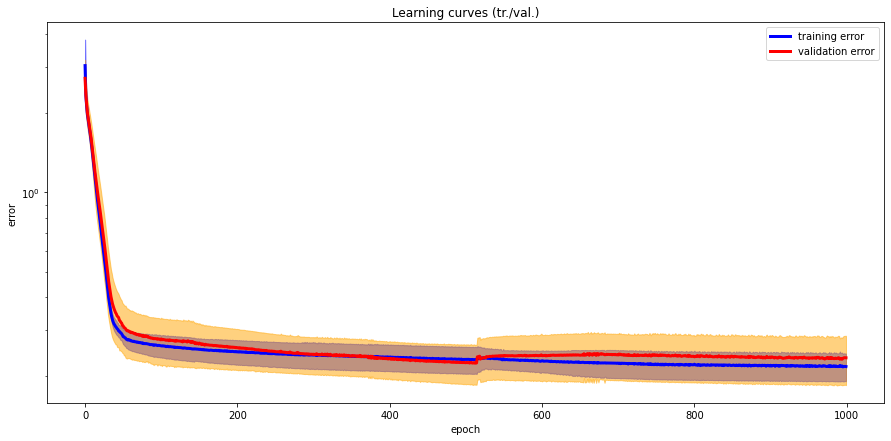

In [47]:
# similarly histories to plot learning curves are precomputed:
best_nn.avg_training_error_history = np.loadtxt('at.csv')
best_nn.std_training_error_history = np.loadtxt('st.csv')
best_nn.avg_val_error_history = np.loadtxt('av.csv')
best_nn.std_val_error_history = np.loadtxt('sv.csv')
best_nn.plot_learning_curves(figsize = (15,7));

The learning curves for the best network; the solid lines represent averages, whereas the shaded areas represent $\pm 1$ std from the average. The fact that these curves are so smooth is not surprising, since the very low initial learning rate ($\sim 0.001$) strongly attenuates the main source of stochasticity i.e. the stochastic gradient.  

Notice that around the 500-th epoch the validation error converges and stays essentially constant, while the training error slightly decreases still. This may lead to overfitting if training were to continue past 1000 epochs, but for the time considered here the difference between the two is smaller than our tolerance parameter (0.01), so early stopping doesn't kick in.

### Weight histograms

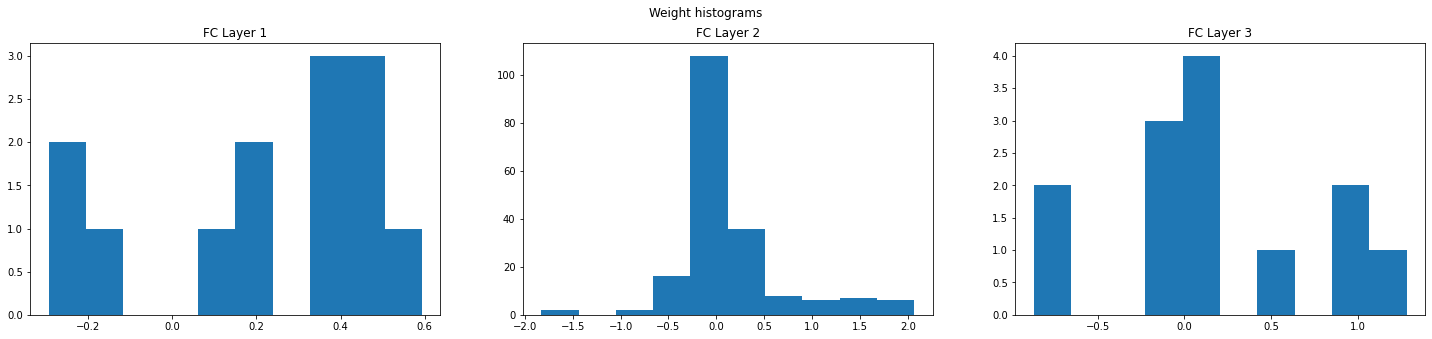

In [48]:
best_nn.plot_weight_histogram();

Notice that weights more than 2 standard deviations away from the mean have been removed before plotting the histogram of each layer to simplify the plots themselves.

# Classification task
## Introduction
In the second part of this assignment we turn to the problem of classifying samples in the *FashionMNIST* dataset, which is a set of 70,000 $28\times 28$ grayscale images depicting one out of 10 different kinds of clothes (e.g. shirts, trousers, etc.). This is conceptually similar to the previous task since it's still supervised learning, the main difference being that this time we want to predict a *discrete* label between 0 and 9, representing the type of clothes in the image. Once again we know that neural networks are effective tools to solve this problem, as long as one finds a good enough set of hyperparameters; for this reason we once again perform random grid search.

## Methods
To perform random grid search we train randomly sampled models using a training set, choose the best one using a validation set, then finally retrain for longer and evaluate performance using a test set. Notice that since the FashionMNIST dataset is very large (70,000 samples) there's no need to use CV; for this reason we partition the dataset once and for all at the beginning of the task, according to the following scheme:
- 60,000 samples are partitioned in a 80-20% fashion to create a training set of 48,000 samples and a validation set of 12,000;
- 10,000 samples are reserved for the test set.
Notice that during training before passing training samples to the network we apply a random affine transformation (up to $\pm 10^\circ$ rotation, up to $\pm 10\%$ translation and up to $\pm 10 \%$ scaling) as a means to combat overfitting, since in this way the network in practice never sees the same sample twice. This is useful to tackle the higher complexity of the model we need in this task, while also helping us partially compensate the images wasted to validation/testing. Validation and test samples are not transformed in any way, since they're not used during training. The only "universal" transformation applied to all samples is a normalization preprocessing, consisting of first mapping the $[0,255]$ interval of grayscale values to $[0,1]$, then normalizing so that the mean is 0 and the standard deviation is 1 - this is good practice, since small and well-behaved inputs help with numerical stability.

To perform classification we use a convolutional neural network, which is a standard tool in image recognition tasks since it effectively allows the network to retain spatial context in the image. For this reason we'd like to design a network with a certain number of convolutional/pooling layers pairs (to effectively extract features from the images) followed by a traditional FC network (to perform the actual classification), but since this model is quite more complex than the one before it would be too time-consuming to test many variations of this architecture; hence we resort to using *LeNet*. LeNet was the first CNN proved to be able to reach almost 100% accuracy in the classification task applied to the MNIST dataset, which is very similar to the FashionMNIST one in terms of features and complexity; for this reason we can confidently expect it to be up to the challenge of learning the FashionMNIST dataset. Due to our faith in LeNet we can therefore fix the network architecture and only perform a random search with the other parameters.

Our architecture of choice is made up of the following layers:
- a convolutional layer with $5\times 5$ kernels and 32 feature maps;
- a max pooling layer with a $2\times 2$ kernel;
- another convolutional layer, with the same parameters as the previous one;
- another max pooling layer, with the same parameters as the above one;
- a linear layer with 128 hidden units, which are fed the flattened output of the convolutional part of the network;
- a final output layer, with 10 neurons representing the 10 possible categories.
The original LeNet architecture actually contained a second hidden fully connected layer with 84 units; we decided to discard it, both to reduce computational load and the number of trainable parameters - which in turn reduces the number of epochs needed to achieve the desired accuracy. Another advantage is that this reduces complexity and therefore the risk of overfitting. While this may seem to make the network potentially less effective it turns out that the final model performance doesn't suffer much from this modification.

The remaining hyperparameters with respect to which we perform a random grid search are the following:
- activation function applied to all layers but the output one (to which we apply a softmax, as is customary when dealing with one-hot encoding); for this we randomly choose between `ReLU` and `LeakyReLU`.
- optimizer: either `Adam` or `SGD` with Nesterov momentum, with uniform probability.
- initial learning rate: loguniformly sampled in the $[10^{-4}, 10^{-2}]$ interval.
- batch size: either 64, 128 or 256 with uniform probability.
- regularization: either no regularization, dropout (drop rate = $5\%-60\%$ with uniform probability), or L1/L2 regularization (strength loguniformly sampled between $[10^{-6}, 10^{-4}]$).
We remark that these ranges are smaller compared to the regression part; the reason is that training is now much more costly, so it makes sense to further reduce the size of the hyperparameters space. Another reason is that with enough training epochs LeNet can perform very well with many of the above, so there's no need to excessively tune parameters.

Also notice that under all circumstances a `CrossEntropy` loss was used, as is customary for multi-class classification tasks.

Random search was performed for $\sim 100$ seeds for just 5 epochs to speed up training, since we mostly care for which hyperparameters guarantee a fast convergence. Afterwards the best network was selected and retrained for 60 epochs (with early stopping active, in case we are able to speed up convergence/reduce overfitting risk by early stopping).


In [49]:
import torch
import torchvision
from torch import nn
from torchvision.datasets import FashionMNIST
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from torch.utils.data import Dataset, DataLoader
from scipy.stats import loguniform
from os.path import exists
from os import listdir
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [50]:
# torchvision.datasets.FashionMNIST('classification_dataset', train = True) # , download = True
# torchvision.datasets.FashionMNIST('classification_dataset', train = False) # , download = True

In [51]:
# the FashionMNIST default torchvision class saves the binary data in tensor format in the data and targets attributes. Once we need to retrieve data, though, the __getitem__ method converts to the PIL image format;
# this makes it quite inefficient and useless, since the only transformation we're interested in can be performed equally as well directly on the tensors. For this reason we overwrite the __getitem__ in a new subclass,
# so that we will deal with tensors only. At the same time this allows us to perform the "static" transformations once and for all (instead of e.g. converting/normalizing on the spot every sample using ToTensor, etc.),
# and to offload the tensors on the GPU from the beginning; these three improvements over the basic class allow us to reduce by more than half CPU load while barely increasing GPU load - while also speeding up training.

class Fashion_MNIST(FashionMNIST): # mind the _ in the class name!
    def __init__(self, root: str, train: bool, download: bool = False, device: str = None):
        super().__init__(root = root, train = train, download = download) 
        self.data = self.data.float() # we convert from uint8 to float to compute means, etc.
        self.data_mean = float(self.data.mean()) # we save overall mean/std as python float for simplicity instead of 0D tensor
        self.data_std  = float(self.data.std())
        self.data_mean_normalized, self.data_std_normalized = self.data_mean / 255, self.data_std / 255

        # from the 0-255 convention to the 0-1 one for images
        self.data /= 255

        # 0 mean, 1 std
        self.data = (self.data - self.data_mean_normalized) / self.data_std_normalized

        # conv2d, transforms etc. expect for the first dimension in any tensor sample to be the number of channels. We only have one (grayscale images), but we still need to add a "fake" dimension
        # to represent this one channel
        self.data = self.data.unsqueeze(1)

        # Put both data and targets on GPU in advance
        if device == 'cuda':
            self.data, self.targets = self.data.to(device), self.targets.to(device)
            self.device = 'cuda'
        else:
            self.device = 'cpu'

    def __getitem__(self, index):
        img_tensor, label = self.data[index], self.targets[index]
        return img_tensor, label # output = tuple(input = 2D float tensor 28*28, label = 0D int tensor) instead of PIL images

    def __len__(self): 
        return len(self.targets) 

    @property
    def raw_folder(self) -> str: # we rewrite this method to avoid issues with folder naming (in the original it's the class name, so we'd need to duplicate files to avoid errors).
        return os.path.join(self.root, 'FashionMNIST', "raw") 

    def plot_sample(self, index, figsize = (4, 4)): # a helper function to convert images to np.array format and visualize them
        fig, ax = plt.subplots(figsize = figsize)
        img, label = self.data[index][0].cpu().numpy(), self.targets[index]
        ax.imshow(img, cmap = 'gray')
        ax.set_title(f'Sample {index} of class {label}')
        return fig, ax

    def train_val_split_tensors(self, training_frac = 0.8, seed: int = 1234): # a helper function to perform the train/validation split in tensor format
        np.random.seed(seed)
        n_samples = len(self)

        train_indices = np.random.choice(n_samples, size = int(training_frac * n_samples), replace = False)
        val_indices   = np.setdiff1d(np.arange(len(self)), train_indices)

        return (self.data[train_indices], self.targets[train_indices]), (self.data[val_indices], self.targets[val_indices])

In [52]:
train_dataset = Fashion_MNIST(root = './classification_dataset', train = True, device = 'cuda')
test_dataset  = Fashion_MNIST(root = './classification_dataset', train = False, device = 'cuda')

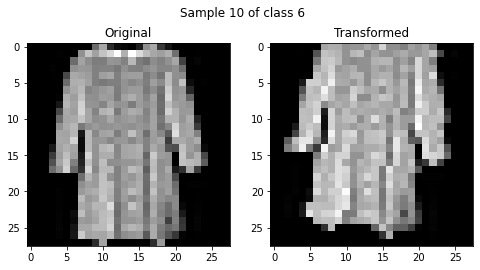

In [53]:
# We now create a standard Dataset class that generalizes the previous one (the one with performance improvements) while also allowing for arbitrary data transformations.

class Fashion_MNIST_transform(Dataset):
    def __init__(self, data, targets, transform): # data and targets attributes from the previous class
        self.data, self.targets = data, targets # this ensures we start from efficient and normalized data
        self.transform = transform        

    def __getitem__(self, index):
        if self.transform is not None:
            img_tensor, label = self.transform(self.data[index]), self.targets[index] # we perform the transformation. One could have defined this __getitem__ in the above class directly, but I prefer to differentiate things
        else:
            img_tensor, label = self.data[index], self.targets[index]
        return img_tensor, label
    
    def __len__(self):
        return len(self.targets)
    
    def get_original(self, index): # to visualize a sample before a transformation we recover the original by "stealing" directly from the data tensors
        img_tensor, label = self.data[index], self.targets[index] 
        return img_tensor, label
    
    def plot_sample_comparison(self, index, figsize = (8, 4)): # helper function to visualize before/after the data transformation
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = figsize)
        img, label = self[index]
        img = img[0].cpu().numpy() 

        img_original, _ = self.get_original(index)
        img_original = img_original[0].cpu().numpy()

        ax[0].imshow(img_original, cmap = 'gray')
        ax[0].set_title('Original')
        ax[1].imshow(img, cmap = 'gray')
        ax[1].set_title('Transformed')
        fig.suptitle(f'Sample {index} of class {label}')
        return fig, ax

# to fill missing values after e.g. a rotation we cannot use 0, since we performed normalization by subtracting the mean and dividing by the standard deviation; 
# for this reason we need to compute the -mean/std factor to be used as the fill argument below
fmnist_train_mean_normalized, fmnist_train_std_normalized = train_dataset.data_mean_normalized, train_dataset.data_std_normalized
data_transform = torchvision.transforms.RandomAffine(degrees = 10, translate = (0.1, 0.1), scale = (0.9, 1.1), fill = -fmnist_train_mean_normalized / fmnist_train_std_normalized)
# we now construct the training/validation datasets with transforms active only for the training one
tr_tuple, val_tuple = train_dataset.train_val_split_tensors()
train_partial_dataset, val_dataset = Fashion_MNIST_transform(*tr_tuple, transform = data_transform), Fashion_MNIST_transform(*val_tuple, transform = None)

train_partial_dataset.plot_sample_comparison(10);

# helper function to create dataloaders from the above datasets in a grid-search friendly way, as batch_size is an argument
def create_train_val_dataloaders(train_partial_dataset, val_dataset, batch_size: int, num_workers: int = 0, seed: int = 1234):
    torch.random.manual_seed(seed)
    torch.cuda.random.manual_seed(seed)
    train_dataloader = DataLoader(train_partial_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)
    val_dataloader   = DataLoader(val_dataset, batch_size = batch_size, shuffle = False, num_workers = num_workers)
    return train_dataloader, val_dataloader

In [54]:
# once again we define a barebones NN class for grid search, then a more refined one with useful methods to predict labels, plot, compute accuracy etc.
# Notice that while conceptually we apply a softmax activation to the output layer in practice we don't actually do this in the forward pass. The reason is that the CrossEntropyLoss actually combines 
# the softmax activation with the negative LL loss, so we don't need to do this ourselves; the reason for this is that loss computation is more accurate when performed on the original tensors, instead of
# their softmax-normalized counterparts (as stated in the pytorch documentation).
# Even when performing predictions we don't need it: since we're not interested in estimating label probabilities we simply use the argmax to select the predicted label

class LeNetLight(nn.Module): # For now we keep memory consumption as low as possible
    def __init__(self, activation_function: str, optimizer: str, 
                 initial_lr: float, batch_size: int, dropout: float = None, l1_reg_strength: float = None, l2_reg_strength: float = None, 
                 loss_fn = nn.CrossEntropyLoss(), device = 'cuda'):
        
        super().__init__()
        self.device = device

        # input = a (1, 28, 28) tensor (1 channel, 28*28 pixels)
        self.conv1_layer = nn.Conv2d(1, 32, kernel_size=5) # (32, 24, 24) output tensor

        self.max_pool_layer = nn.MaxPool2d(kernel_size=2) # (32, 12, 12) output tensor
        
        self.conv2_layer = nn.Conv2d(32, 64, kernel_size=5) # (64, 8, 8) output tensor

        # then we reapply the maxpool => (64, 4, 4) output tensor => 64 * 4 * 4 = 1024 inputs for the FC linear layer

        self.fc1_layer = nn.Linear(1024, 128)
        self.fc2_layer = nn.Linear(128, 10) # modified LeNet

        self.activation = getattr(nn, activation_function)()
        
        if dropout is not None and 0 < dropout < 1:
            self.dropout = dropout
            self.dropout_layer = nn.Dropout(p = dropout)
        else:
            self.dropout = None
            self.dropout_layer = nn.Identity() # if no dropout the dropout layer is the identity, i.e. it actually does nothing

        if optimizer == 'SGD': # if optimizer is SGD we add Nesterov momentum with a 0.9 fairly standard value
            self.optimizer = torch.optim.SGD(params = self.parameters(), momentum = 0.9, nesterov = True, lr = initial_lr)
        else:
            self.optimizer = getattr(torch.optim, optimizer)(params = self.parameters(), lr = initial_lr)
        
        self.batch_size = batch_size
        self.loss_fn = loss_fn
        self.l1_reg_strength = l1_reg_strength
        self.l2_reg_strength = l2_reg_strength

        if l1_reg_strength is None and l2_reg_strength is None:
            self.reg = lambda: torch.tensor([0], dtype = float, requires_grad = True).to(self.device)
        if l1_reg_strength is not None:
            self.reg = lambda: (sum(((w.abs()).sum() for w in self.parameters()))*self.l1_reg_strength).to(self.device)
        if l2_reg_strength is not None:
            self.reg = lambda: (sum(((w**2).sum() for w in self.parameters()))*self.l2_reg_strength).to(self.device)            
    
    def forward(self, x): # forward pass function
        x = self.conv1_layer(x)
        x = self.activation(x)
        x = self.max_pool_layer(x)
        x = self.dropout_layer(x)
        
        x = self.conv2_layer(x)
        x = self.activation(x)
        x = self.max_pool_layer(x)
        x = self.dropout_layer(x)

        x = x.view(-1, 1024) # flatten to prepare for FC layers
        x = self.fc1_layer(x)
        x = self.activation(x)
        x = self.dropout_layer(x)
        
        x = self.fc2_layer(x) # no dropout for the output layer
        return x

    def train_single_epoch(self, train_dataloader): # function to be iterated inside the fit loop (no cv)
        self.train() # enable dropout etc.
        tr_err_single_epoch = 0

        for x_batch, y_batch in tqdm(train_dataloader):
            output = self(x_batch)
            loss   = self.loss_fn(output, y_batch) + self.reg()
            self.optimizer.zero_grad() # reset gradients
            loss.backward() # backpropagation
            self.optimizer.step() # update weights
            tr_err_single_epoch += loss.detach().cpu().numpy() # save current training error
        
        tr_err_single_epoch /= len(train_dataloader) # len of a dataloader = n. of batches
        return tr_err_single_epoch

    @torch.no_grad()
    def val_single_epoch(self, val_dataloader):
        self.eval() # disable dropout etc.
        val_err_single_epoch = 0

        for x_batch, y_batch in val_dataloader:
            output = self(x_batch)
            loss   = self.loss_fn(output, y_batch)
            val_err_single_epoch += loss.detach().cpu().numpy()
        
        val_err_single_epoch /= len(val_dataloader)
        return val_err_single_epoch

    # main training method. I like scikit-learn's self-contained API, hence what follows
    def fit(self, train_partial_dataset, val_dataset, max_n_iter: int = 100, min_n_iter: int = 3, patience: int = 10, tol: float = 0.01, seed: int = 1234, verbose: bool = True, num_workers: int = 0):
        if seed is not None: # default seed to ensure reproducibility
            torch.random.manual_seed(seed)

        training_dataloader, validation_dataloader = create_train_val_dataloaders(train_partial_dataset, val_dataset, batch_size = self.batch_size, num_workers = num_workers) # dependent on self.batch_size

        self.training_error_history, self.val_error_history = np.zeros(max_n_iter), np.zeros(max_n_iter) # no CV --> no average over dataloaders --> we have a single value to use as an estimate of tr./val. errors
        self.best_val_error = np.Inf
        patience_counter = 0

        loading = trange(max_n_iter) # if verbose else range(max_n_iter) # useful toggle during training/debugging
        for epoch in loading:
            if verbose:
                print(f'Training {epoch=}') # useful to track training
            tr_err  = self.training_error_history[epoch] = self.train_single_epoch(train_dataloader = training_dataloader)
            val_err = self.val_error_history[epoch] = self.val_single_epoch(val_dataloader = validation_dataloader)
            if verbose:
                print(f'{epoch=}: {tr_err=}, {val_err=}') # useful to track training

            if epoch > min_n_iter:
                if val_err > self.best_val_error + tol:
                    patience_counter += 1
                else:
                    self.best_val_error = val_err
                    patience_counter = 0
                if patience_counter > patience:
                    break
        n_executed_epochs = epoch + 1 # + 1 to go from 0, N-1 (python) to 1, N (human readable) counting scheme 
        if n_executed_epochs < max_n_iter:
            self.best_val_error_epoch = n_executed_epochs - patience_counter
        else:
            self.best_val_error_epoch = max_n_iter - patience_counter

In [55]:
def sample_hyperparameters(seed): # same as before, but with smaller hp ranges and no network architecture sampling
    np.random.seed(seed)    
    activation_function = np.random.choice(['ReLU', 'LeakyReLU'])
    optimizer = np.random.choice(['SGD','Adam'])
    initial_lr = loguniform.rvs(1e-4, 1e-2)
    batch_size = int(np.random.choice([64, 128, 256]))
    # Regularization
    reg = {'dropout':None, 'l1_reg_strength':None, 'l2_reg_strength':None}
    reg_type = np.random.choice([None, *reg.keys()])
    if reg_type is not None:
        if reg_type == 'dropout':
            reg['dropout'] = loguniform.rvs(0.05, 0.6)
        else:
            reg[reg_type] = loguniform.rvs(1e-6, 1e-4)
    
    hyperparameters = {'activation_function':activation_function,'optimizer':optimizer,
                       'initial_lr':initial_lr, 'batch_size':batch_size, **reg}
    
    return hyperparameters

# Random grid search code, to be used in a separate script
def run_one_instance(seed, max_n_iter = 5, verbose = False):
    hyperparameters = sample_hyperparameters(seed)
    model = LeNetLight(**hyperparameters).cuda()
    model.fit(train_partial_dataset, val_dataset, max_n_iter = max_n_iter, verbose = False) # 5! Speriamo vada bene
    torch.save(model.state_dict(), f'D:/NNDL/homework/HW1/LeNet_models/seed_{seed}.pth')
    print(f'Saved to file D:/NNDL/homework/HW1/LeNet_models/seed_{seed}.pth')

    np.savetxt(f'D:/NNDL/homework/HW1/LeNet_models/seed_{seed}_th.csv', model.training_error_history)
    print(f'Saved to file D:/NNDL/homework/HW1/LeNet_models/seed_{seed}_th.csv')
    np.savetxt(f'D:/NNDL/homework/HW1/LeNet_models/seed_{seed}_vh.csv', model.val_error_history)
    print(f'Saved to file D:/NNDL/homework/HW1/LeNet_models/seed_{seed}_vh.csv')

    return {'seed':seed, **hyperparameters, 'best_val_error':model.best_val_error, 'best_val_error_epoch':model.best_val_error_epoch}

def run_multiple_instances(start_seed, stop_seed):
    base_file_path = 'D:/NNDL/homework/HW1/classification_random_search_single_files/'

    hp = ['seed', 'activation_function', 'optimizer', 'initial_lr', 'batch_size', 'dropout', 'l1_reg_strength', 'l2_reg_strength', 'best_val_error', 'best_val_error_epoch']
    
    for seed in range(start_seed, stop_seed):
        print(f'-------------------Training with seed {seed}-------------------')
        print('parameters: \n', sample_hyperparameters(seed))
        file_path = base_file_path + f'seed_{seed}.csv'
        df = pd.DataFrame({s:[] for s in hp})
        df = df.append(run_one_instance(seed), ignore_index = True)
        df.astype({'seed':int, 'best_val_error_epoch':int, 'batch_size':int}).to_csv(file_path, index_label = False)
        print(f'Saved to file {file_path}')

In [56]:
# assemble random grid search results in a single dataframe
results_file_path = './classification_random_search_result.csv'
if not exists(results_file_path):
    csvs_folder = './classification_random_search_single_files/'
    df = pd.concat((pd.read_csv(csvs_folder + f) for f in listdir(csvs_folder))) # pd.concat(generator i.e. via generator comprehension)
    df.to_csv(results_file_path, index_label = False)
else:
    df = pd.read_csv(results_file_path)
# show results
best_nn_df = df.nsmallest(10, 'best_val_error').reset_index(drop = True)
# best_nn_df.index += 1
display(best_nn_df)

if not exists('./classification_best_networks.csv'):
    best_nn_df.to_csv('./classification_best_networks.csv')

,seed,activation_function,optimizer,initial_lr,batch_size,dropout,l1_reg_strength,l2_reg_strength,best_val_error,best_val_error_epoch
0,76,LeakyReLU,Adam,0.004345,256,NaN,0.000002,NaN,0.292613,5
1,46,LeakyReLU,Adam,0.001861,256,NaN,NaN,0.000033,0.299189,5
2,77,LeakyReLU,Adam,0.001925,128,NaN,NaN,NaN,0.301939,5
3,24,ReLU,Adam,0.002506,128,0.08639,NaN,NaN,0.302539,4
4,93,LeakyReLU,Adam,0.002065,128,0.06491,NaN,NaN,0.304144,5
5,1,LeakyReLU,Adam,0.002758,128,NaN,NaN,0.000100,0.304331,4
6,79,LeakyReLU,Adam,0.000863,64,NaN,NaN,NaN,0.305079,5
7,83,ReLU,Adam,0.002331,64,NaN,NaN,NaN,0.307547,4
8,72,ReLU,Adam,0.002337,128,NaN,0.000005,NaN,0.308096,5
9,74,ReLU,Adam,0.003708,256,NaN,NaN,NaN,0.309280,4


## Results
The best performing network over 5 epochs is:

In [57]:
display(best_nn_df.nsmallest(1, 'best_val_error'))
best_nn_seed = int(best_nn_df.nsmallest(1, 'best_val_error').seed)

,seed,activation_function,optimizer,initial_lr,batch_size,dropout,l1_reg_strength,l2_reg_strength,best_val_error,best_val_error_epoch
0,76,LeakyReLU,Adam,0.004345,256,NaN,0.000002,NaN,0.292613,5


We now retrain this network for (up to) 60 epochs ("up to" since we use early stopping).

In [58]:
# first we define an improved class containing some functions to measure performance
class LeNet(LeNetLight):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def plot_learning_curves(self, smooth: int = None, figsize: tuple = (10,5)):
        if smooth is not None:
            tr_h  = np.convolve(self.training_error_history, np.ones(smooth)/smooth, mode = 'valid') # fir filter L-point running average to smooth our signal if needed
            val_h = np.convolve(self.val_error_history, np.ones(smooth)/smooth, mode = 'valid')
        else:
            tr_h  = self.training_error_history
            val_h = self.val_error_history
        
        tr_h, val_h = tr_h[tr_h > 0], val_h[val_h > 0] # so that the plot looks better when early stopping occurs

        epochs = np.arange(len(tr_h))
        fig, ax = plt.subplots(figsize = figsize)
        ax.plot(epochs, tr_h,  label = 'training error',   c = 'r', linewidth = 3)
        ax.plot(epochs, val_h, label = 'validation error', c = 'b', linewidth = 3)
        ax.set_yscale('log')
        ax.set_xlabel('epoch')
        ax.set_ylabel('error')
        ax.legend()
        ax.set_title(f'Learning curves (tr./val.) (total training duration = {len(tr_h)} epochs)')

        return fig, ax

    def plot_weight_histogram(self, figsize: tuple = (25, 5), ignore_outliers: bool = False):
        fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = figsize) # 2 conv, 2 FC
        layers = [self.conv1_layer, self.conv2_layer, self.fc1_layer, self.fc2_layer]
        titles = ['Conv. layer 1', 'Conv. layer 2', 'FC layer 1', 'FC layer 2']
        fig.suptitle('Weight histograms')
        for i, axx in enumerate(ax.flatten()):
            w = layers[i].weight.cpu().detach().numpy().flatten()
            if ignore_outliers:
                w = w[np.abs(w - w.mean()) < 2*w.std()] # for a better looking histogram in case we don't have L1/L2 regularization on
            axx.hist(w) 
            axx.set_title(titles[i])

        return fig, ax

    def predict(self, x):
        self.eval()
        return self(x).argmax(1) # look for the max along columns since each row is a different sample
        # this effectively eliminates the need for a softmax activation in the output layer when predicting labels

    def test_accuracy(self, test_dataset):
        y_pred = self.predict(test_dataset.data)
        y_true = test_dataset.targets
        correct_pred_frac = y_pred.eq(y_true).float().mean().cpu().detach()
        return float(correct_pred_frac)

    def compute_confusion_matrix(self, test_dataset, normalize = None):
        mat = confusion_matrix(y_true = test_dataset.targets.cpu().numpy(), y_pred = self.predict(test_dataset.data).cpu().detach().numpy(), normalize = normalize)
        return mat

    def plot_confusion_matrix(self, test_dataset, figsize = (10, 10), normalize = None):
        disp_mat = ConfusionMatrixDisplay(self.compute_confusion_matrix(test_dataset = test_dataset, normalize = normalize))
        fig, ax  = plt.subplots(figsize = figsize)
        disp_mat.plot(cmap = plt.cm.Blues, ax = ax)
        # ax.patch.set_facecolor('white')
        ax.set_title(f'Fraction of correct test set predictions = {self.test_accuracy(test_dataset):.2%}')
        return fig, ax

    def plot_conv1_layer_kernels(self, figsize: tuple = (10, 10)):
        fig, ax = plt.subplots(nrows = 4, ncols = 8, figsize = figsize)
        for i, axx in enumerate(ax.flatten()):
            mat = self.conv1_layer.weight[i].squeeze(0).cpu().detach().numpy()
            axx.imshow(mat, cmap = 'gray')
            axx.set_title(f'{i+1}')
            axx.axis('off')
        # fig.suptitle('Conv. layer 1 feature maps')
        return fig, ax

    def plot_conv2_layer_kernels(self, figsize: tuple = (10, 10)):
        fig, ax = plt.subplots(nrows = 8, ncols = 8, figsize = figsize)
        for i, axx in enumerate(ax.flatten()):
            mat = self.conv2_layer.weight[i].squeeze(0).cpu().detach().numpy()
            print(self.conv2_layer.weight[i].shape)
            axx.imshow(mat, cmap = 'gray')
            axx.set_title(f'{i+1}')
            axx.axis('off')
        return fig, ax
        
    
    def plot_wrongly_classified_samples(self, dataset, n_rows: int = 3, n_cols: int = 5, figsize: tuple = (20, 10)):
        n_samples = n_rows*n_cols
        y_pred = self.predict(dataset.data)
        y_true = dataset.targets
        indices_wrongly_classified_samples = np.arange(len(y_true))[~y_true.eq(y_pred).cpu().detach().numpy()]
        idx_array = indices_wrongly_classified_samples[:n_samples]

        fig, ax = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = figsize)
        for i, idx in enumerate(idx_array):
            img = dataset.data[idx].squeeze(0).cpu().numpy()
            yp, yt = y_pred[idx], y_true[idx]
            axx = ax.flatten()[i]
            axx.imshow(img, cmap = 'gray')
            axx.set_title(f'Predicted = {yp}, True = {yt}')
            axx.axis('off')
        return fig, ax

In [59]:
best_nn = LeNet(**sample_hyperparameters(best_nn_seed)).cuda()
# best_nn.fit(train_partial_dataset, val_dataset, max_n_iter = 60, tol = 0.0001) # pretrained
best_nn.load_state_dict(torch.load(f'./classification_best_models_parameters_long_training/seed_{best_nn_seed}.pth'))
best_nn.training_error_history = np.loadtxt(f'./classification_best_models_parameters_long_training/seed_{best_nn_seed}_th.csv')
best_nn.val_error_history = np.loadtxt(f'./classification_best_models_parameters_long_training/seed_{best_nn_seed}_vh.csv')
print('test accuracy:', best_nn.test_accuracy(test_dataset))
print('val. accuracy:', best_nn.test_accuracy(val_dataset))

test accuracy: 0.895799994468689
val. accuracy: 0.902999997138977


After training the network reaches a validation accuracy of $90.30\%$ and a test one of $89.57\%$. This result is quite good, and probably hard to improve upon. Indeed one may wonder why the test accuracy is so "low", since the original LeNet architecture could reach almost $100\%$ accuracy while ours cannot; the answer to this is the following. Notice that the original LeNet paper focused on the MNIST dataset, which is more simplistic than the FashionMNIST one and thus easier to learn; hence it's not surprising that our final performance is slightly ($\sim 10\%$) worse. It's possible that by using the exact same architecture as in the original paper (i.e. the one with an extra FC layer at the end) and/or by running a more thourough random grid search (i.e. by training more models and/or for longer) one could obtain slightly better performance; and yet since a) our result is good enough, b) it's possible that the extra complexity of FashionMNIST would prevent us from reaching $\sim 100\%$ test accuracy with our simple architecture, and c) improving upon this already good result would clearly require much more computational resources, we are content with the obtained network.

Another reason to believe obtained performance is good enough is that our network already achieves almost a human level performance; to prove this is the case we plot the confusion matrix.


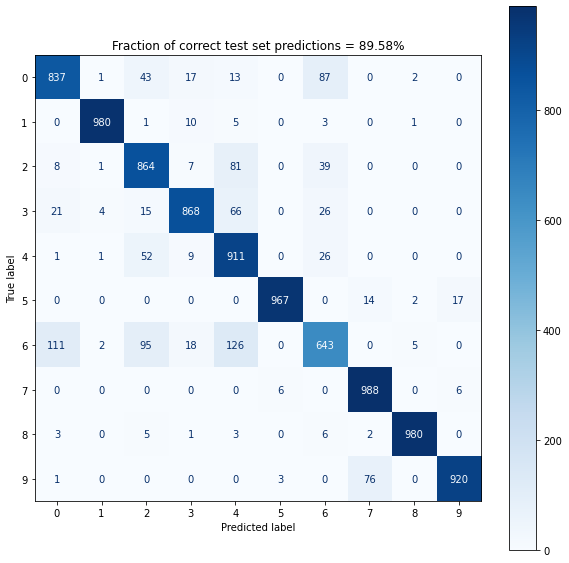

In [60]:
# print('test accuracy:', best_nn.test_accuracy(test_dataset))
best_nn.plot_confusion_matrix(test_dataset, figsize = (10,10));

We notice that the largest source of mistaken predictions is the set of samples with label 6, to which the network assigns label 4 too often. To interpret these values let's check the FashionMNIST one-hot encoding dictionary:

In [61]:
pd.read_csv('fashion_mnist_dict.csv')

,label,description
0,0,T-shirt/top
1,1,Trouser
2,2,Pullover
3,3,Dress
4,4,Coat
5,5,Sandal
6,6,Shirt
7,7,Sneaker
8,8,Bag
9,9,Ankle boot


This means that sometimes our network mistakenly assigns the label 'coat' to images of type 'shirt'. This is perfectly acceptable, actually; from low resolution images of the two even a human expert may have a hard time trying to distinguish them, since they both look like long-sleeved T-shirts. Similarly we notice that our network classified 111 shirts as T-shirts, and another 95 as pullovers; once again even a human expert may do similar mistakes.

To visualize this we can plot a few of these samples:

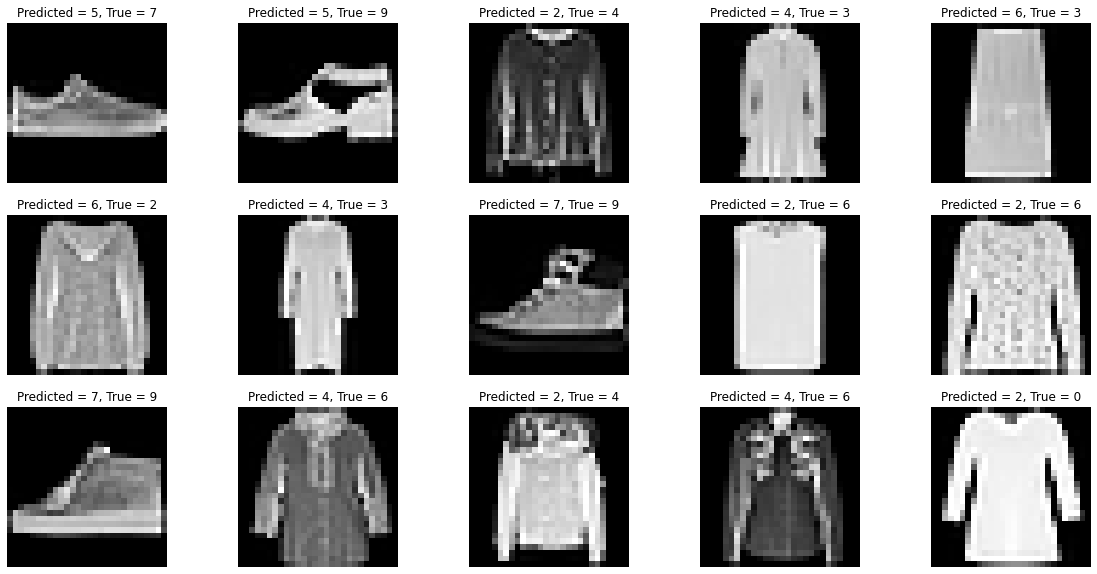

In [62]:
best_nn.plot_wrongly_classified_samples(test_dataset);

Indeed we notice that these samples are challenging even for a human expert: for example the first two are clearly shoes, but it's difficult to tell the first is a sneaker and the second an ankle boot. Similarly the other plotted samples, which suffer from the T-shirt/shirt/pullover or dress/coat ambiguity explained above.

These points ensure us that the dataset itself is limiting the performance of the network in a significant way, and makes it harder to believe that performance could be *significantly* improved using the approached proposed above. This also clarifies why we earlier stated that the FashionMNIST is harder to learn than the MNIST one: more samples are intrinsically ambiguous, even for a human expert.

To further diagnose training and performance the appendix reports learning curves, weight histograms and the confusion matrix for the test set.

We now proceed to plot feature maps and activation profiles for the convolutional layers, to better interpret the network's activity (similarly to what we did in the regression task).

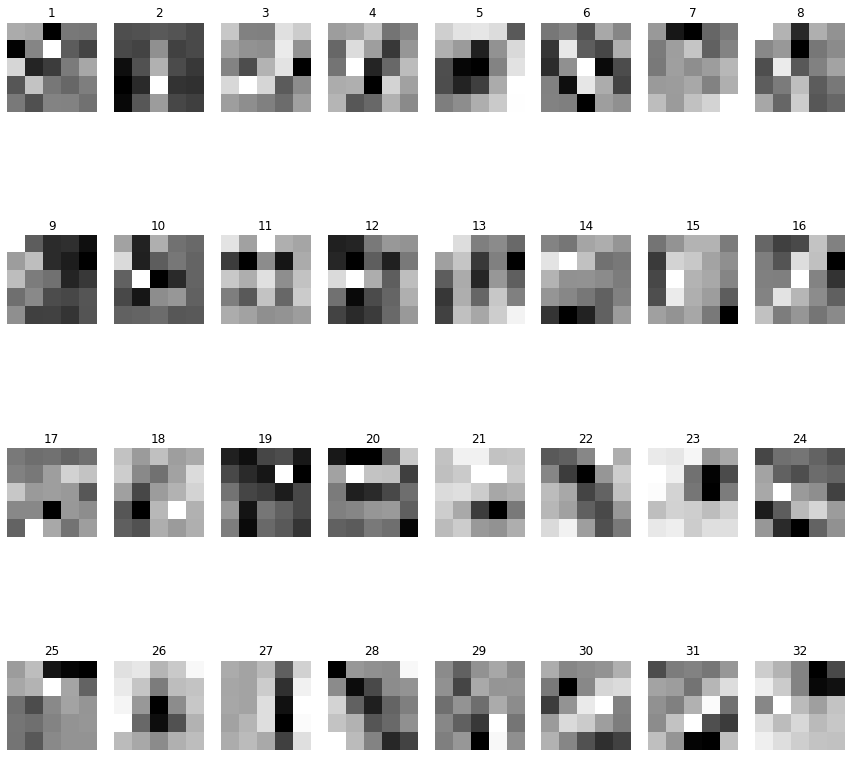

In [63]:
best_nn.plot_conv1_layer_kernels((15, 15));

We notice that the first convolutional layer's kernels are relatively simple, and they act as edge detectors or as cropping devices. To better understand what they're actually doing we plot their effect on a sample (activation profiles).

Original sample:
Activation profiles (conv. layer 1) :


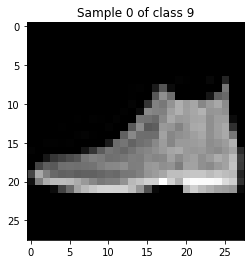

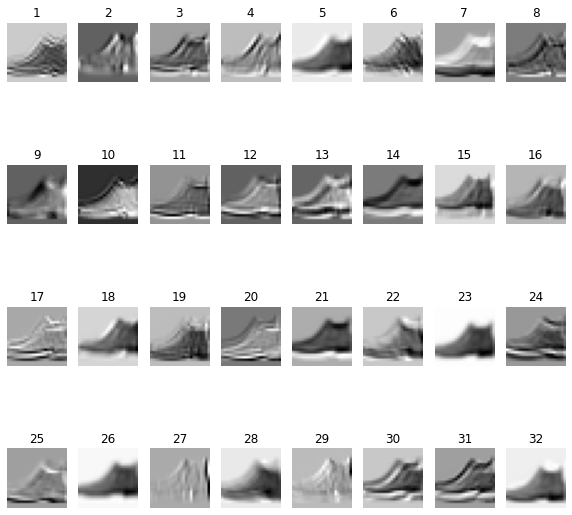

In [64]:
model = LeNet(**sample_hyperparameters(best_nn_seed)).cuda() # a copy to avoid messing with the layers
model.load_state_dict(torch.load(f'./classification_best_models_parameters_long_training/seed_{best_nn_seed}.pth'))

class SaveOutput: # https://towardsdatascience.com/the-one-pytorch-trick-which-you-should-know-2d5e9c1da2ca
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []

save_output = SaveOutput()

hook_handles = []

for layer in model.modules():
    if isinstance(layer, nn.Conv2d):
        handle = layer.register_forward_hook(save_output)
        hook_handles.append(handle)

def get_conv_layers_activation(model, dataset, index):
    img, _ = dataset[index]
    model.eval()
    try:
        _ = model(img)
    except:
        _ = model(img.unsqueeze(0)) # if a single sample is provided we need to add an extra dim. at the beginning to comply with the model's vectorization requirements
    out = save_output.outputs
    return out

idx = 0
conv1_out, conv2_out = get_conv_layers_activation(model, test_dataset, index = idx)
conv1_out, conv2_out = conv1_out.squeeze(0), conv2_out.squeeze(0) # plot a single sample

print('Original sample:')
test_dataset.plot_sample(idx);

print('Activation profiles (conv. layer 1) :')
fig, ax = plt.subplots(nrows = 4, ncols = 8, figsize = (10, 10))
for i, axx in enumerate(ax.flatten()):
    mat = conv1_out[i].squeeze(0).cpu().detach().numpy()
    axx.imshow(mat, cmap = 'gray')
    axx.set_title(f'{i+1}')
    axx.axis('off')

Now it's more clear that the kernels mostly act as edge detectors. Notice that the 32 images are smaller due to the max pooling layer.

## Appendix (classification task)

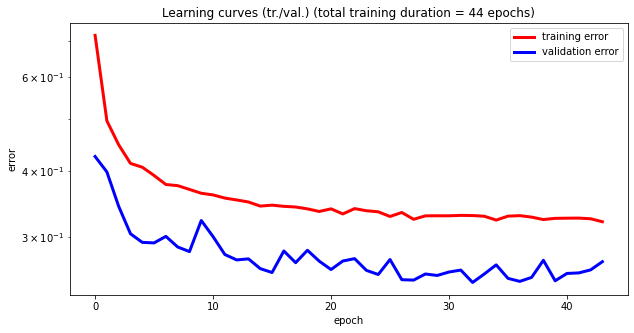

In [65]:
best_nn.plot_learning_curves();

Training and validation curves for the best LeNet architecture and the FashionMNIST dataset.

We remark that the validation error is always lower than the training error; this behaviour is easily explained. Indeed notice that only during the training phase we randomly transform samples; these fact makes it so that the network has a harder time learning from the training set, whereas the validation set in fixed and therefore has less noise. This is similar to the regression task, where the extra noise in the training set made the test error lower than the training one.

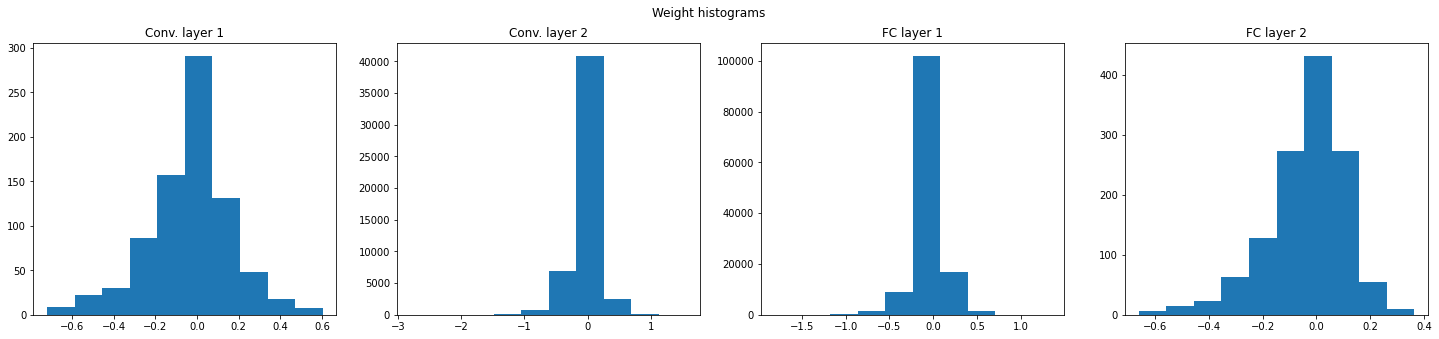

In [66]:
best_nn.plot_weight_histogram();

Weights histogram. Notice that weights are relatively small in absolute value and centered around zero; this is of course a consequence of the L1 regularization employed by the best network.

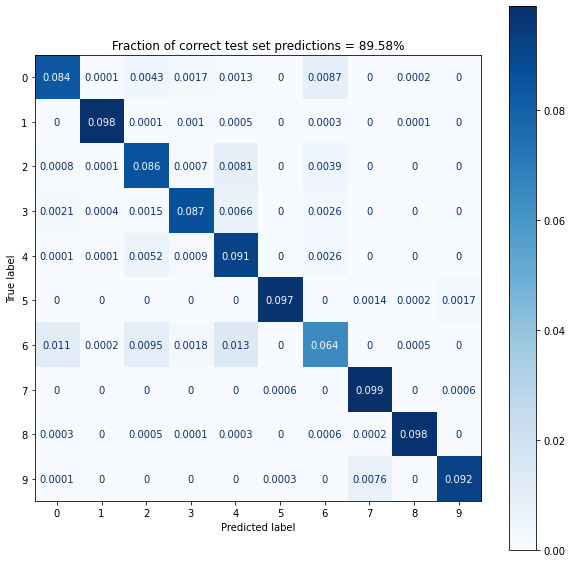

In [67]:
best_nn.plot_confusion_matrix(test_dataset, figsize = (10,10), normalize = 'all');

Normalized confusion matrix.

Activation profiles (conv. layer 2) :


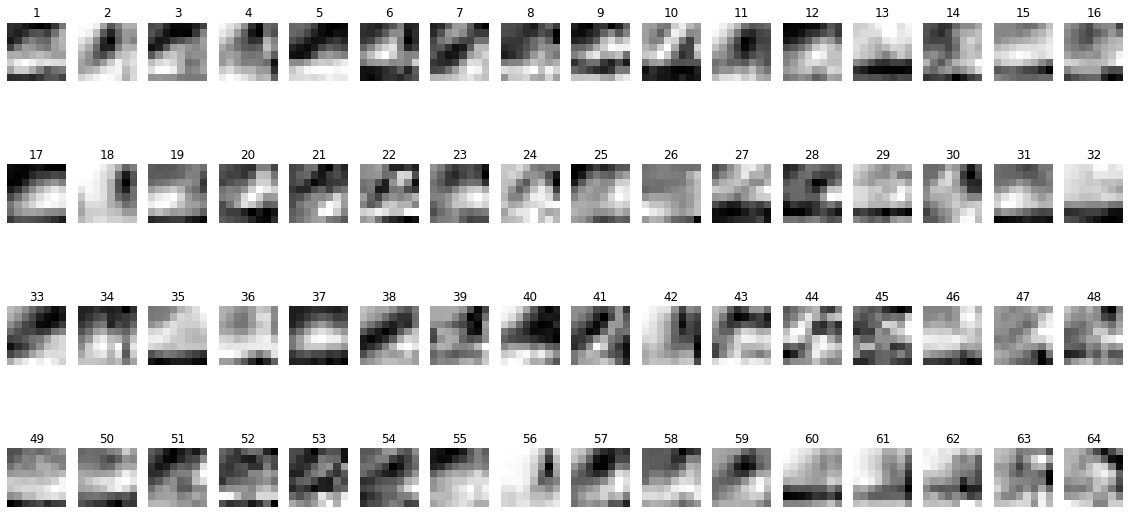

In [68]:
print('Activation profiles (conv. layer 2) :')
fig, ax = plt.subplots(nrows = 4, ncols = 16, figsize = (20, 10))
for i, axx in enumerate(ax.flatten()):
    mat = conv2_out[i].squeeze(0).cpu().detach().numpy()
    axx.imshow(mat, cmap = 'gray')
    axx.set_title(f'{i+1}')
    axx.axis('off')

Activation profiles of the second convolutional layer (same input sample as before). These are harder to interpret, and also even smaller due to the second max pooling layer.